# Visualizing Large Scale Recordings
Now that we are familiar with the structure of an NWB file as well as the groups encapsulated within it, we are ready to work with the data. In this lesson you will learn to search the NWB file for its available data and plot visualizations such as raster plots.

Below, we'll import some now familiar packages and once again work with the dataset we obtained in Lesson 1. This should look very familiar to you by now!

<mark>**Note #1**: The code below will only work if you downloaded this NWB dataset on the last page.</mark>

<mark>**Note #2**: Some of the cells below contain <code>try</code> and <code>except</code> to catch instances where these notebooks are not run in a properly configured coding environment. You can focus on the code *after* <code>try</code> -- that's the code we want to run.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# import necessary packages
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget
import matplotlib.pyplot as plt
import numpy as np

# set the filename
filename = '../Lesson_1/000006/sub-anm369962/sub-anm369962_ses-20170310.nwb'

# assign file as an NWBHDF5IO object
try:
    io = NWBHDF5IO(filename, 'r')   
    nwb_file = io.read() # read the file
    print('NWB file found and read.')
    print(type(nwb_file)) 
except:
    print('You have not downloaded this file yet. Please complete the previous page.')

NWB file found and read.
<class 'pynwb.file.NWBFile'>


The first group that we will look at is `units` because it contains information about spikes times in the data. This time, we will subset our dataframe to only contain neurons with `Fair` spike sorting quality. This means that the researchers are more confident that these are indeed isolated neurons.  

> Need a refresher on how we subset a dataframe? Review the [Pandas page](https://nwb4edu.github.io/Data_Science_In_Python/Pandas.html#subsetting).

In [2]:
# Get the units data frame
units_df = nwb_file.units.to_dataframe()
 
# Select only "Fair" units
fair_units_df = units_df[units_df['quality']=='Fair']

# Print the subsetted dataframe
fair_units_df.head()

,depth,quality,cell_type,spike_times,electrodes
id,,,,,
2,665.0,Fair,unidentified,"[329.95417899999956, 330.01945899999953, 330.0...",x y z imp ...
5,715.0,Fair,unidentified,"[331.09961899999956, 332.14505899999955, 333.3...",x y z imp ...
6,715.0,Fair,unidentified,"[329.91129899999953, 329.92869899999954, 330.0...",x y z imp ...
7,765.0,Fair,unidentified,"[330.26357899999954, 330.3849389999996, 330.60...",x y z imp ...
10,815.0,Fair,unidentified,"[329.8969389999996, 329.94389899999953, 329.95...",x y z imp ...


The `spike_times` column contains the times at which the recorded neuron fired an action potential. Each neuron has a list of spike times for their `spike_times` column. Below, we'll return the first 10 spike times for a given neuron. 

In [3]:
# Return the first 10 spike times for your neuron of choice
unit_id = 5
print(units_df['spike_times'][unit_id][:10])

[331.099619 332.145059 333.362499 333.395059 334.149659 334.178019
 334.183059 334.612499 340.767066 340.916546]


<div class="alert alert-info">A <b>spike raster plot</b> displays the spiking of neurons over time. In a raster plot, each row corresponds to a different neuron or a different trial, and the x-axis represents the time. Each small vertical line in the plot represents the spiking of a neuron. Raster plots are useful to concisely reveal firing rate correlations between groups of neurons or trends in activity over time.</div>

Below, we'll create a function called `plot_raster()` that creates a raster plot from the `spike_times` column in `units`. `plot_raster()` takes the following arguments:

- `unit_df`: dataframe containing spike time data
- `neuron_start`: index of first neuron of interest 
- `neuron_end`: index of last neuron of interest
- `start_time`: start time for desired time interval (in seconds)
- `end_time`: end time for desired time interval (in seconds)

The plot is ultimately created using the function [`plt.eventplot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.eventplot.html).

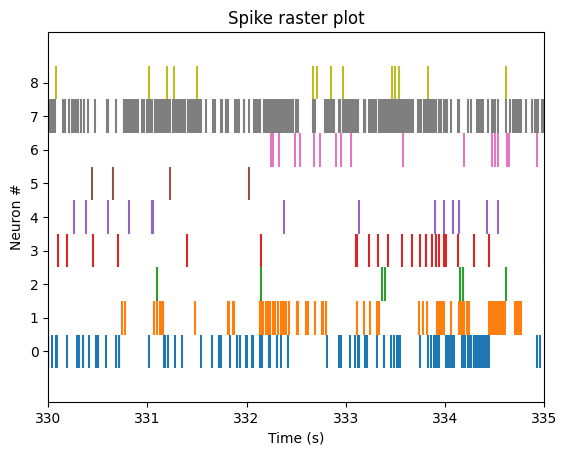

In [4]:
# Function for creating raster plots for Units group in NWB file 
def plot_raster(units_df,neuron_start,neuron_end,start_time,end_time): 
    '''
    Takes a dataframe containing the units group of a nwb file (units_df) and creates 
    a raster plot with a given set of neurons (indexed by neuron_start, neuron_end) and a start and end time.
    '''
    
    neural_data = units_df['spike_times'][neuron_start:neuron_end] # Select the data
    num_neurons = neuron_end - neuron_start # Calculate # of neurons
    my_colors = ['C{}'.format(i) for i in range(num_neurons)]  #Generate a list of colors (C0, C1...)
    
    plt.eventplot(neural_data,colors=my_colors)  # Plot our raster plot 

    plt.xlim([start_time,end_time]) # Set axis limits to only include points in our data
    
    # Label our figure 
    plt.title('Spike raster plot')
    plt.ylabel('Neuron #')
    plt.xlabel('Time (s)')
    plt.yticks(np.arange(0,num_neurons))
    plt.show()

# Use our new function
plot_raster(units_df, neuron_start = 2, neuron_end = 11, start_time = 330, end_time = 335)

The plot above is only contains neural spikes from nine neurons in a five second time interval. While there are many spikes to consider in this one graph, each neuron has much more than five seconds worth of spike recordings! To summarize these spikes over time, we can compute a **firing rate**.

## Binning Firing Rates 

Raster plots are great for seeing individual neural spikes, but difficult to see the overall firing rates of the units. To get a better sense of the overall firing rates of our units, we can bin our spikes into time bins of 1 second using the function below, `plot_firing_rates()`.

In [5]:
def plot_firing_rates(spike_times, start_time = None, end_time = None):
    '''
    plots the binned firing rate for the spike times in the list it is given in 1 second time bins.

    Parameters
    ----------
    spike_times : list
                  spike times, in seconds

    start_time  : int
                  start time for spike binning in seconds; sets lower-most bound for x axis
                  
    end_time    : int
                  end time for spike binning in seconds ; sets upper-most bound for x axis
    '''
    
    # Assign total number of bins 
    num_bins = int(np.ceil(spike_times[-1]))
    binned_spikes = np.empty(num_bins)
  
    # Assign the frequency of spikes over time
    for j in range(num_bins):
        binned_spikes[j] = len(spike_times[(spike_times>j)&(spike_times<j+1)])
          
    plt.plot(binned_spikes)
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (Hz)')
        
    if (start_time != None) and (end_time != None):
        plt.xlim(start_time, end_time)

Let's use the function we just created to plot our data. Below, we will store all of the spike times from the same unit as above as `single_unit` and plot the firing rates over time.

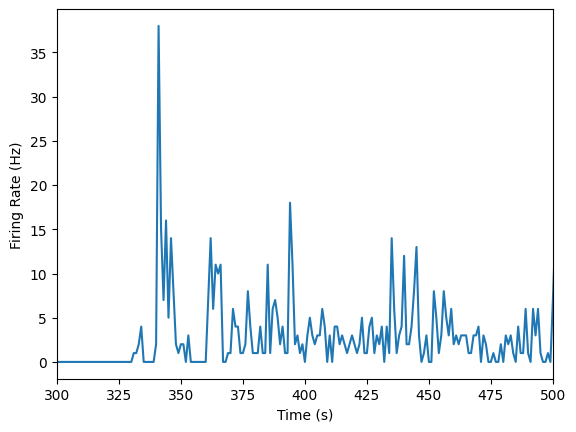

In [6]:
# Plot our data
single_unit = units_df['spike_times'][unit_id]
plot_firing_rates(single_unit,300,500)

<div class="alert alert-success"><b>Task</b>: Modify the <code>plot_firing_rates</code> function above so that it returns <code>binned_spikes</code>. You'll need this for the Lesson 2 problem set!</div>

## Compare firing rates at different depths of cortex

The units in our data were recorded from various cortical depths, therefore we can compare the firing units from differing cortical depths to test for differing firing rates. Let's first take a look at the distribution of depth from our units.

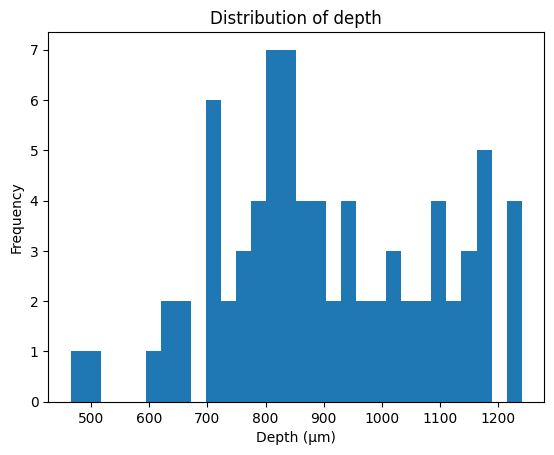

In [7]:
# Plot distribution of neuron depth 
plt.hist(units_df['depth'], bins=30)
plt.title('Distribution of depth')
plt.xlabel('Depth (\u03bcm)') # The random letters in here are to create a mu symbol using unicode
plt.ylabel('Frequency')
plt.show()

We will compare one unit recorded from 1165 microns to one unit recorded from 715 microns.

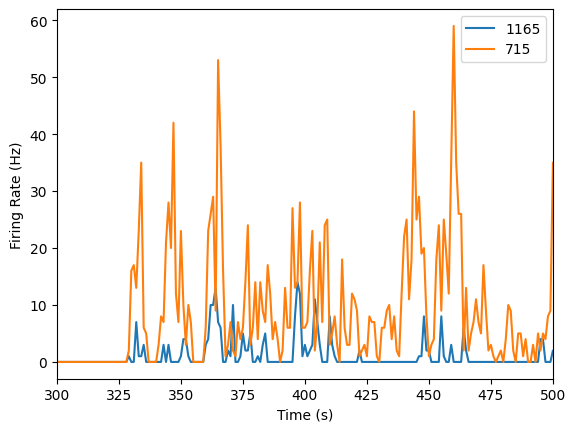

In [8]:
# Assign dataframes for different depths 
depth_1165 = units_df[units_df['depth']==1165]
depth_715 = units_df[units_df['depth']==715]

# Create list of containing 1 entry from each depth
neural_list_1165 = depth_1165['spike_times'].iloc[0]
neural_list_715 = depth_715['spike_times'].iloc[0]

# Plot firing rates
plot_firing_rates(neural_list_1165, 300, 500)
plot_firing_rates(neural_list_715, 300, 500)
plt.legend(['1165','715'])
plt.show()

It looks like the neuron that's more superficial (at a depth of 715 microns) has a higher firing rate! But we'd certainly need more data to make a conclusive argument about that.

<hr>

## Lesson 2 Wrap Up

In this lesson, we showed you how to import raw extracellular electrophysiology data from an NWB file to perform a simple version of spike sorting. We then worked with previously sorted "units" from an NWB file to illustrate common ways of visualizing extracellular recordings.

Hopefully now you can:

    ✔️ Identify the processing steps in extracellular experiments
    ✔️ Implement spike sorting on extracellular recording data
    ✔️ Generate and interpret common visualizations of extracellular recording data

Before moving on, try the Lesson #2 problem set to test your understanding and to put some of these new skills to work. 💪
<hr>

## Additional resources

* For more ideas about how to play with this dataset, see this [Github repository](https://github.com/vathes/DJ-NWB-Economo-2018/blob/master/notebooks/Economo-2018-examples.ipynb).
* For information about how to explore spike sorting quality metrics in particular NWB files, see [this OpenScope page](https://alleninstitute.github.io/openscope_databook/visualization/visualize_unit_metrics.html
* For ideas on how to analyze this data based on other elements of the experiment (e.g., the stimuli) see [this OpenScope page](https://alleninstitute.github.io/openscope_databook/visualization/visualize_unit_responses.html).